In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
           "Viscera weight", "Shell weight", "Age"])


df_features = df.copy()
df_labels = df_features.pop('Age')
df_features = np.array(df_features)

In [2]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

y_train = y_train.reset_index(drop=True)

sc = StandardScaler()
sc.fit(X_train)
sc.fit(X_test)

(2656, 7) (2656,) (664, 7) (664,)


StandardScaler()

In [3]:
def build_model():
    model = keras.Sequential([layers.Dense(64, activation='relu'),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(1)])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

k = 4
num_val_samples = len(X_train) // k
num_epochs = 100
all_scores = []
best_mae_per_fold = []  # 各foldごとの最小MAEとそのエポック数を格納するリスト

for i in range(k):
    print(f'Processing fold #{i}')
    
    val_data = X_train[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([X_train[:i*num_val_samples], X_train[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i*num_val_samples], y_train[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history['val_mae']
    
    min_mae = min(mae_history)
    min_mae_epoch = mae_history.index(min_mae) + 1  # インデックスをエポック数に変換
    best_mae_per_fold.append((min_mae, min_mae_epoch))
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print("Best MAE per fold:")
for fold, (mae, epoch) in enumerate(best_mae_per_fold, 1):
    print(f"Fold {fold}: Minimum MAE = {mae} at epoch {epoch}")

print('全ての点数', all_scores)
print('点数の平均', np.mean(all_scores))

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Best MAE per fold:
Fold 1: Minimum MAE = 1.545966625213623 at epoch 67
Fold 2: Minimum MAE = 1.4912644624710083 at epoch 98
Fold 3: Minimum MAE = 1.3963040113449097 at epoch 64
Fold 4: Minimum MAE = 1.4695700407028198 at epoch 100
全ての点数 [1.591490626335144, 1.7898550033569336, 1.4791821241378784, 1.469570279121399]
点数の平均 1.5825245082378387


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


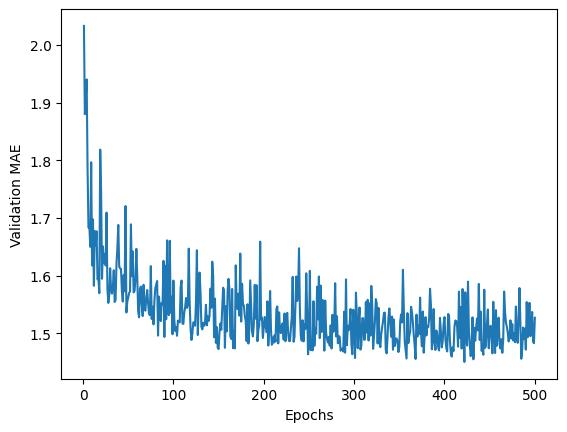

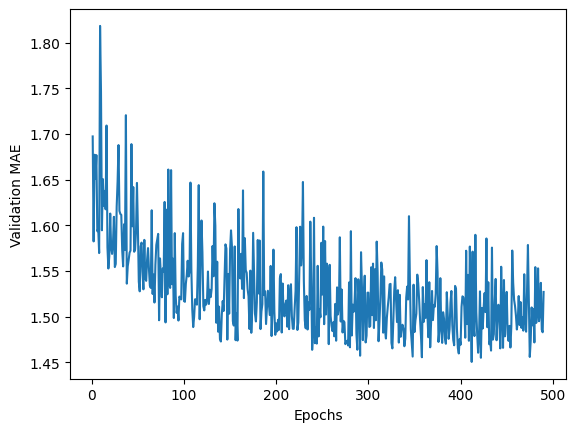

In [4]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f'Processing fold #{i}')
    
    val_data = X_train[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([X_train[:i*num_val_samples], X_train[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i*num_val_samples], y_train[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history)+1), truncated_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

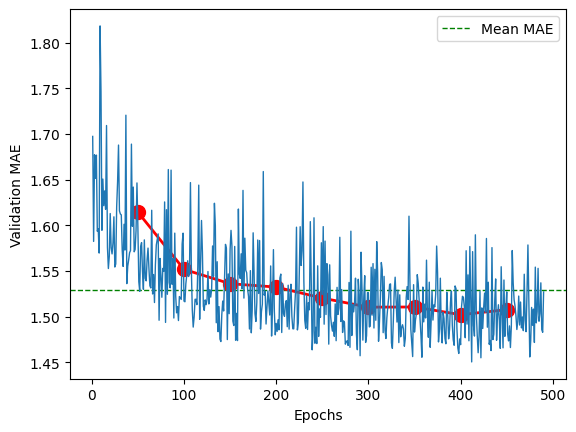

In [5]:
mean_mae = np.mean(truncated_mae_history)
plt.axhline(y=mean_mae, color='green', linestyle='--', linewidth=1, label='Mean MAE')

mean_mae_every_50_epochs = [np.mean(truncated_mae_history[i-50:i]) for i in range(50, len(truncated_mae_history) + 1, 50)]

# 100エポックごとのインデックス
indices = [i*50 for i in range(1, len(mean_mae_every_50_epochs) + 1)]

# 平均MAEの線をプロット
plt.plot(indices, mean_mae_every_50_epochs, color='red', marker='o', markersize=10, linestyle='-', linewidth=2)

# MAEのプロット
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history, linewidth=1)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()